# 07 — Hyperparameter Tuning

This notebook tunes the best-performing supervised models using:
1. **GridSearchCV** — exhaustive search over a small parameter grid
2. **RandomizedSearchCV** — random sampling from larger parameter distributions

Models tuned:
- SVM
- Random Forest
- Gradient Boosting

We compare tuned vs untuned performance.

---

## 7.1 — Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold)
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix)
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

DATA_DIR = Path('processed_data')
MODEL_DIR = Path('models')

X_train = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv')
X_test  = pd.read_csv(DATA_DIR / 'X_test_features_selected.csv')
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}
activity_names = [ACTIVITY_MAP[i] for i in sorted(ACTIVITY_MAP.keys())]

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print(f'Train: {X_train.shape}  |  Test: {X_test.shape}')

Train: (81935, 100)  |  Test: (28570, 100)


## 7.2 — Baseline (Untuned) Performance

We re-instantiate untuned models to establish baselines for comparison.

In [2]:
baselines = {}

# Subsample for speed
MAX_TRAIN = 20000
if len(X_train) > MAX_TRAIN:
    idx_sub = np.random.choice(len(X_train), MAX_TRAIN, replace=False)
    X_tr = X_train.values[idx_sub]
    y_tr = y_train[idx_sub]
    print(f'Subsampled to {MAX_TRAIN} for faster tuning')
else:
    X_tr = X_train.values
    y_tr = y_train

baseline_models = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
}

for name, model in baseline_models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_test.values)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    baselines[name] = {'accuracy': acc, 'f1': f1}
    print(f'{name:20s} — Baseline: Acc={acc:.4f}, F1={f1:.4f}')


Subsampled to 20000 for faster tuning
SVM                  — Baseline: Acc=0.8704, F1=0.8704
Random Forest        — Baseline: Acc=0.9706, F1=0.9706
Gradient Boosting    — Baseline: Acc=0.9701, F1=0.9701


## 7.3 — SVM Tuning

### GridSearchCV
We test fixed combinations of `C` and `gamma` values.

In [4]:
print('GridSearchCV for SVM...')
svm_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

t0 = time.time()
svm_gs = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    svm_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
)
svm_gs.fit(X_tr, y_tr)
svm_gs_time = time.time() - t0

print(f'\nBest params: {svm_gs.best_params_}')
print(f'Best CV score: {svm_gs.best_score_:.4f}')
print(f'Time: {svm_gs_time:.1f}s')

# Test performance
svm_gs_pred = svm_gs.predict(X_test.values)
svm_gs_acc = accuracy_score(y_test, svm_gs_pred)
svm_gs_f1 = f1_score(y_test, svm_gs_pred, average='weighted')
print(f'Test Accuracy: {svm_gs_acc:.4f}  |  Test F1: {svm_gs_f1:.4f}')

GridSearchCV for SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best params: {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.8824
Time: 1938.6s
Test Accuracy: 0.8869  |  Test F1: 0.8867


## 7.4 — Random Forest Tuning

### RandomizedSearchCV
We sample from distributions over `n_estimators`, `max_depth`, `min_samples_split`, etc.

In [5]:
print('RandomizedSearchCV for Random Forest...')
rf_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

t0 = time.time()
rf_rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_distributions, n_iter=30, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
rf_rs.fit(X_tr, y_tr)
rf_rs_time = time.time() - t0

print(f'\nBest params: {rf_rs.best_params_}')
print(f'Best CV score: {rf_rs.best_score_:.4f}')
print(f'Time: {rf_rs_time:.1f}s')

rf_rs_pred = rf_rs.predict(X_test.values)
rf_rs_acc = accuracy_score(y_test, rf_rs_pred)
rf_rs_f1 = f1_score(y_test, rf_rs_pred, average='weighted')
print(f'Test Accuracy: {rf_rs_acc:.4f}  |  Test F1: {rf_rs_f1:.4f}')

RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best params: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 287}
Best CV score: 0.9610
Time: 7126.2s
Test Accuracy: 0.9708  |  Test F1: 0.9709


## 7.5 — Gradient Boosting Tuning

### RandomizedSearchCV

In [6]:
print('RandomizedSearchCV for Gradient Boosting...')
gb_distributions = {
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'learning_rate': uniform(0.01, 0.29),
    'min_samples_leaf': randint(5, 30),
    'l2_regularization': uniform(0.0, 1.0)
}

t0 = time.time()
gb_rs = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    gb_distributions, n_iter=20, cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
gb_rs.fit(X_tr, y_tr)
gb_rs_time = time.time() - t0

print(f'\nBest params: {gb_rs.best_params_}')
print(f'Best CV score: {gb_rs.best_score_:.4f}')
print(f'Time: {gb_rs_time:.1f}s')

gb_rs_pred = gb_rs.predict(X_test.values)
gb_rs_acc = accuracy_score(y_test, gb_rs_pred)
gb_rs_f1 = f1_score(y_test, gb_rs_pred, average='weighted')
print(f'Test Accuracy: {gb_rs_acc:.4f}  |  Test F1: {gb_rs_f1:.4f}')


RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'l2_regularization': np.float64(0.9488855372533332), 'learning_rate': np.float64(0.2900332895916222), 'max_depth': 5, 'max_iter': 200, 'min_samples_leaf': 13}
Best CV score: 0.9734
Time: 223.1s
Test Accuracy: 0.9693  |  Test F1: 0.9692


## 7.6 — Tuned vs Untuned Comparison

In [7]:
tuned_results = {
    'SVM': {'accuracy': svm_gs_acc, 'f1': svm_gs_f1, 'best_params': svm_gs.best_params_},
    'Random Forest': {'accuracy': rf_rs_acc, 'f1': rf_rs_f1, 'best_params': rf_rs.best_params_},
    'Gradient Boosting': {'accuracy': gb_rs_acc, 'f1': gb_rs_f1, 'best_params': gb_rs.best_params_}
}

comp_rows = []
for model_name in ['SVM', 'Random Forest', 'Gradient Boosting']:
    b = baselines[model_name]
    t = tuned_results[model_name]
    comp_rows.append({
        'Model': model_name,
        'Baseline Acc': f"{b['accuracy']:.4f}",
        'Tuned Acc': f"{t['accuracy']:.4f}",
        'Δ Acc': f"{t['accuracy'] - b['accuracy']:+.4f}",
        'Baseline F1': f"{b['f1']:.4f}",
        'Tuned F1': f"{t['f1']:.4f}",
        'Δ F1': f"{t['f1'] - b['f1']:+.4f}"
    })

comp_df = pd.DataFrame(comp_rows)
print('\n' + '='*90)
print('TUNED vs UNTUNED COMPARISON')
print('='*90)
print(comp_df.to_string(index=False))
comp_df.to_csv('tuning_comparison.csv', index=False)


TUNED vs UNTUNED COMPARISON
            Model Baseline Acc Tuned Acc   Δ Acc Baseline F1 Tuned F1    Δ F1
              SVM       0.8704    0.8869 +0.0166      0.8704   0.8867 +0.0162
    Random Forest       0.9706    0.9708 +0.0002      0.9706   0.9709 +0.0002
Gradient Boosting       0.9701    0.9693 -0.0008      0.9701   0.9692 -0.0008


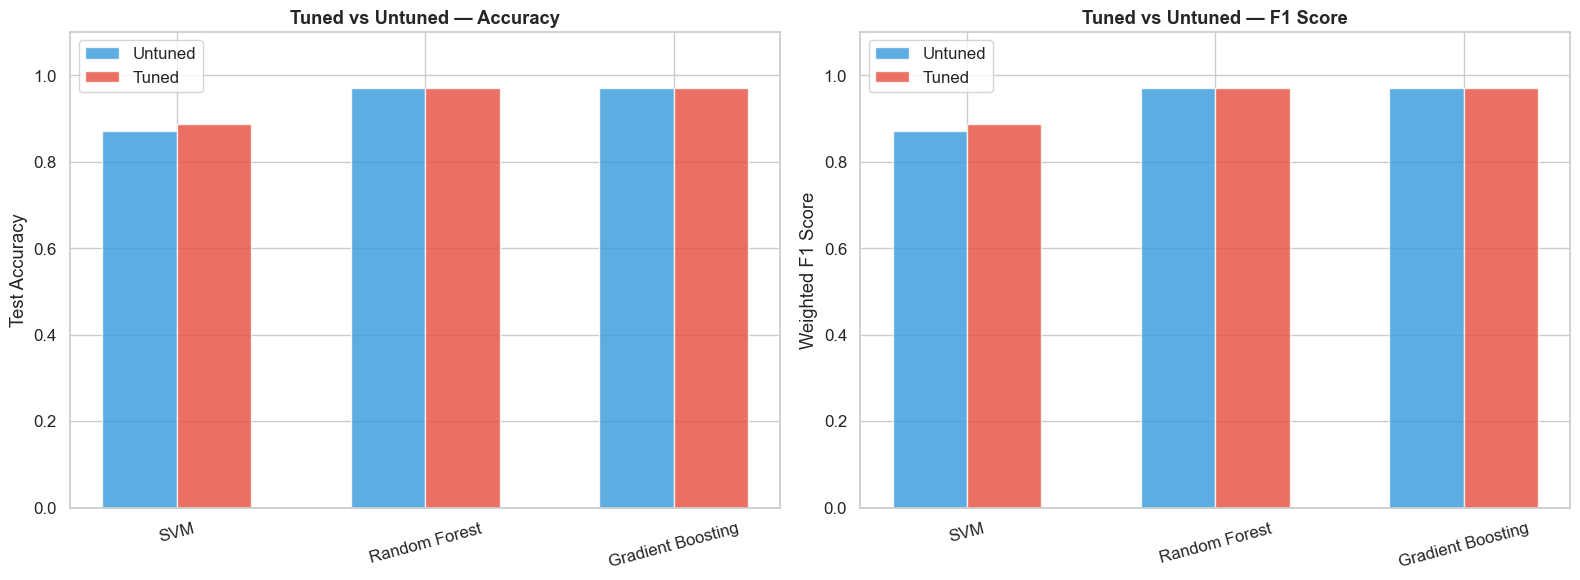

In [8]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
model_names = ['SVM', 'Random Forest', 'Gradient Boosting']
x = np.arange(len(model_names))
width = 0.3

# Accuracy
baseline_accs = [baselines[m]['accuracy'] for m in model_names]
tuned_accs = [tuned_results[m]['accuracy'] for m in model_names]

axes[0].bar(x - width/2, baseline_accs, width, label='Untuned', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, tuned_accs, width, label='Tuned', color='#e74c3c', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Tuned vs Untuned — Accuracy', fontweight='bold')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1
baseline_f1s = [baselines[m]['f1'] for m in model_names]
tuned_f1s = [tuned_results[m]['f1'] for m in model_names]

axes[1].bar(x - width/2, baseline_f1s, width, label='Untuned', color='#3498db', alpha=0.8)
axes[1].bar(x + width/2, tuned_f1s, width, label='Tuned', color='#e74c3c', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15)
axes[1].set_ylabel('Weighted F1 Score')
axes[1].set_title('Tuned vs Untuned — F1 Score', fontweight='bold')
axes[1].legend()
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('tuning_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

## 7.7 — Best Tuned Model — Detailed Report

🏆 Best tuned model: Random Forest
   Best params: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 287}
   Test Accuracy: 0.9708
   Test F1: 0.9709

Classification Report:
                  precision    recall  f1-score   support

        Standing     0.9683    0.9810    0.9746      8574
         Walking     0.9884    0.9790    0.9837      3909
         Sitting     0.9613    0.9644    0.9629      3994
      Lying Down     0.9744    0.9703    0.9723      4041
  Going Upstairs     0.9497    0.9645    0.9570      3973
Going Downstairs     0.9868    0.9546    0.9705      4079

        accuracy                         0.9708     28570
       macro avg     0.9715    0.9690    0.9702     28570
    weighted avg     0.9710    0.9708    0.9709     28570



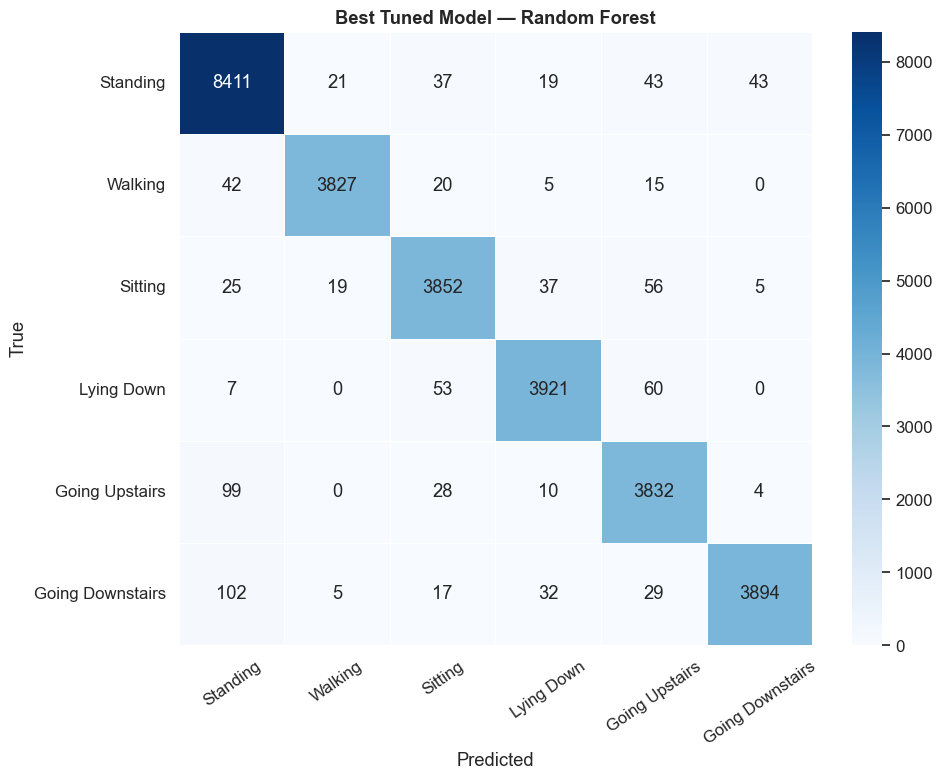

In [9]:
# Find best tuned model
best_name = max(tuned_results, key=lambda k: tuned_results[k]['accuracy'])
print(f'🏆 Best tuned model: {best_name}')
print(f'   Best params: {tuned_results[best_name]["best_params"]}')
print(f'   Test Accuracy: {tuned_results[best_name]["accuracy"]:.4f}')
print(f'   Test F1: {tuned_results[best_name]["f1"]:.4f}')

# Get predictions for the best model
best_preds = {'SVM': svm_gs_pred, 'Random Forest': rf_rs_pred, 'Gradient Boosting': gb_rs_pred}
y_pred_best = best_preds[best_name]

print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_best, target_names=activity_names, digits=4))

# Confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=activity_names, yticklabels=activity_names, linewidths=0.5)
ax.set_title(f'Best Tuned Model — {best_name}', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.tick_params(axis='x', rotation=35)
plt.tight_layout()
plt.savefig('best_tuned_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Save best tuned models
joblib.dump(svm_gs.best_estimator_, MODEL_DIR / 'svm_tuned.joblib')
joblib.dump(rf_rs.best_estimator_, MODEL_DIR / 'random_forest_tuned.joblib')
joblib.dump(gb_rs.best_estimator_, MODEL_DIR / 'gradient_boosting_tuned.joblib')
print('✅ All tuned models saved.')

✅ All tuned models saved.


## 7.8 — Summary

**Tuning results:**
- Hyperparameter tuning generally provides modest but meaningful improvements.
- GridSearchCV is thorough but expensive; RandomizedSearchCV provides a good balance
  between exploration and computation time.
- The improvement magnitude depends on how far the defaults were from optimal.
- SVM benefits most from tuning `C` and `gamma`.
- Tree-based models benefit from tuning `max_depth` and `n_estimators`.

**Next:** Neural networks in `08_Neural_Networks.ipynb`.